In [2]:
# Import des modules nécessaires et définition de fonctions pour tracer les courbes
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import LinearRegression
from IPython.display import display, Markdown

def plotIt(x,y, title="sortie", xlab="X", ylab="Y"):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')

    seaborn.despine(ax=ax, offset=0)

def plotScat(x,y, title="sortie", xlab="X", ylab="Y"):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')

    seaborn.despine(ax=ax, offset=0)

def plotIt2(x1,y1,x2,y2,title="sortie", xlab="X", ylab="Y", legends=""):
    fig, ax = plt.subplots()
    ax.plot(x1, y1, x2,y2)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')
    ax.legend(legends)

    seaborn.despine(ax=ax, offset=0)

def plotIt2s(x1,y1,x2,y2,title="sortie", xlab="X", ylab="Y", legends=""):
    fig, ax = plt.subplots()
    ax.plot(x1, y1,'rx')
    ax.plot(x2, y2)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')
    ax.legend(legends)

    seaborn.despine(ax=ax, offset=0)

# a=np.arange(0,10,0.1)
# b=a**2
# plotIt(a,b, title="test")

Linéarisation d'un sonde de température NTC
===========================================

La linéarisation d'une caractéristique consiste à calculer l'équation de la tangente à la courbe autour d'un point donné. Le cas échéant, l'inversion de la courbe est plus simple.

## Exemple avec une thermo-résistance NTC

La caractéristique de la sonde NTC est donnée par une relation de la forme suivante :

$$
R(T) = R_0 \left( e^{\beta ( {1 \over T} - {1 \over {T_0}}) } \right)
$$

**Attention :** Les températures sont exprimées en Kelvin !

Le coefficient $\beta$ peut être calculé pour deux points connus d'une sonde par la relation

$$
\beta = \frac{T_1 \cdot T_2}{T_2-T_1} \cdot \ln{\left(\frac{R_1}{R_2}\right)}
$$

En pratique, le coefficient $\beta$ est donné par le fabricant pour une plage de température donnée. (cf. datasheet NTCS0603)

## Courbe de la thermorésistance

Pour tracer la courbe de la thermorésistance, on définit la relation et on calcule la valeur de la résistance pour une plage de températures.

In [9]:
def Rntc(T, T0, R0, B):
    K0=273.15
    Tk=T+K0
    T0k=T0+K0
    return R0*np.exp(B*(1/Tk-1/T0k))
    

In [38]:
# Définition d'une plage de température et calcul des valeurs de résistance.
vT=np.arange(0, 100, 0.1)
vRt = Rntc(vT, T0=25, R0=1000, B=3170)

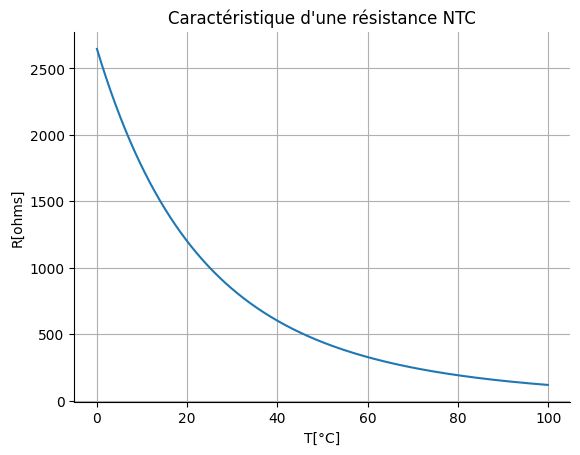

In [89]:
plotIt(vT,vRt, xlab="T[°C]", ylab="R[ohms]", title="Caractéristique d'une résistance NTC")
plt.savefig("../images/caracteristiqueNTC.png")

## Linéarisation


On veut linéariser cette caractéristique autour de 20°C en utilisant la *tangente*. On part de la relation qui donne la valeur de la résistance comme fonction de la température. 

On utilise *sympy* pour nous aider à résoudre le problème. La fonction qui nous intéresse peut être définie algébriquement comme suit :

In [85]:
import sympy as sp
T, T0, R0, B = sp.symbols('T T0 R0 B')
eqR = R0*sp.exp(B*(1/T-1/T0))

In [86]:
eqR

R0*exp(B*(-1/T0 + 1/T))

Pour faire une linéarisation, on calcule la pente de la courbe à un point de la courbe. Les valeurs proches peuvent être calculées avec une relation de la forme ci-dessous.
$$
y = f(x), \quad y_{lin} = f(x_0) + S \cdot (x-x_0),
\quad
S = \frac {d f(m)}{dm} \bigg|_{m_0}
$$
$S$ est la pente de la fonction à un point $x0$.

Le module *sympy* permet de trouver la dérifée d'une expression assez simplement. 

- On obtient la dérivée de la fonction qu'on a définit *eqR* avec l'expression *eqR.diff(T)*
- On peut évalue la valeur du résultat avec *res.subs(variable, valeur)*. Pour remplacer plusieurs valeurs, il suffit d'itérer (res.subs().subs()...)

### EX1 : Calculez la fonction linéarisée $y_{lin}$ autour d'un point T = 20 °C.

## Solution

In [42]:
dR=eqR.diff(T)

In [43]:
dR

-B*R0*exp(B*(-1/T0 + 1/T))/T**2

In [47]:
K0=273.15
S20=dR.subs(B,3170).subs(T0,25+K0).subs(R0,1000).subs(T,20+K0)
R20=eqR.subs(B,3170).subs(T0,25+K0).subs(R0,1000).subs(T,20+K0)
print("Equation linéaire : R = {} + {} * (T-20)".format(R20,S20))

Equation linéaire : R = 1198.82818752104 + -44.2217994767232 * (T-20)


Fonction linéarisée

In [50]:
def Rntc_lin(T):
    return R20 + S20*(T-20)

In [51]:
Rntc_lin(20)

1198.82818752104

### EX2 : Tracez la nouvelle fonction sur un graphique avec la caractéristique de la résistance NTC

## Solution

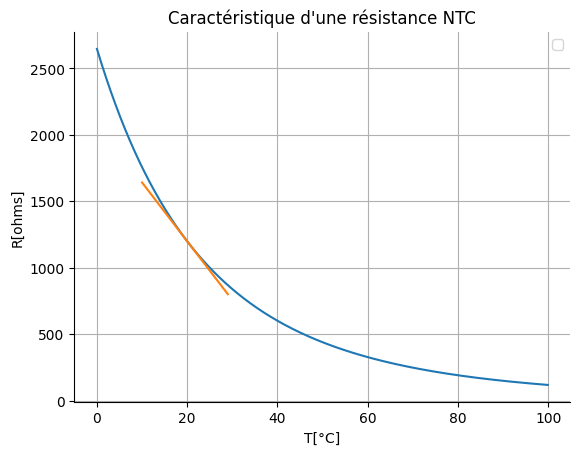

In [88]:
vTl=np.arange(10,30)
vRl=Rntc_lin(vTl)
plotIt2(vT,vRt, vTl, vRl, xlab="T[°C]", ylab="R[ohms]", title="Caractéristique d'une résistance NTC")

### EX3 : Quelle est l'erreur maximum sur une plage de 20 à 30°C ?

In [78]:
# Calcul de la différence de valeur de résistance calculée par la fonction
Rntc_lin(30)-Rntc(30, T0=25, R0=1000, B=3170)

-82.5425284661429

In [79]:
Rntc(30, T0=25, R0=1000, B=3170)

839.1527212199521

In [80]:
Rntc_lin(30)

756.610192753809

### EX4 : Calculez quelle sera l'erreur d'estimation de la température si on utilise la courbe linéarisée inverse au lieu de la caractéristique réelle

In [81]:
Rntc

<function __main__.Rntc(T, T0, R0, B)>

In [82]:
Rm=sp.Symbol('Rm')
Tr=sp.solve(eqR-Rm,T)

In [83]:
Tr

[B/log(Rm*exp(B/T0)/R0)]

In [84]:
Tlin=Tr[0].subs(Rm,756).subs(T0,25+K0).subs( R0,1000).subs(B,3170)-K0
print("La fonction linéarisée donnera {:.1f} °C pour une température réelle de 30 °C. L'erreur d'estimation sera de {:.1f} °C.".format(Tlin, Tlin-30))

La fonction linéarisée donnera 33.1 °C pour une température réelle de 30 °C. L'erreur d'estimation sera de 3.1 °C.


### EX5 : Comment réduire l'erreur due à la fonction de linéarisation ?

### Solution

On pourrait ajouter un petit offset pour équilibrer l'erreur.